### Homework 3:  Master Regression on the Ames Housing Dataset

This homework is meant to be a more open ended, exploratory way for students to complete their assignment for Homework project #3. 

Instead of doing the pre-assigned tasks in the other projects given, you can use this homework as a chance to develop your own model using the Ames Housing dataset.  It's meant to be a way to continue to refine the techniques and methods discussed in Unit 3 and make them your own.

Your homework assignment will be to synthesize the lessons taught in Unit 3, and present a coherent walk through of how you approached the modeling process.

**What You Will Turn In:**

A jupyter notebook with code and commentary that walks us through the following:

 - Exploratory Data Analysis on the original data
   - What values are highly correlated?  
   - Are there unusual values anywhere that might cause problems?  Are there values of the `SalePrice` column that are out of sync with what we might normally expect?
   
 - How were missing values imputed? 
 - What cross validation strategy did you use and why?
   - How did you interpret their results?
 - Your choice of analytical technique and how you decided to cross validate its best parameters
 - The use of pipelines to streamline your data processing and ensure correct alignment between training and test sets
 - Strategies you used to try and improve your score (it's okay if they didn't work -- just show us what you tried to do and why)
 - What features ended up having important causal impact on the target variable?
  
The end result should be a coherent walk through of how you approached the problem and developed a coherent solution to evaluate your data.

Some other notes: 

 - You can use the original dataset that was used in Unit 3's labs if you feel like sticking with this will help you retain the most important insights of the class.  
 - You also have the option of using the full dataset (provided in the data section) and/or portions of it.
  - For example:  setting up the pipeline framework we created in class and then using that to incrementally bring in new columns, experiment with different ways of encoding them and then updating your pipeline is a useful way to extend the classes main teachings.  You could also just try and work with the whole thing if you're feeling courageous.
 - Making kaggle submissions to demonstrate whether or not your changes resulted in actual improvements is great, but not required if you struggle with the Kaggle UI.
 - If you feel more comfortable, you can walk through this **same process** using the `bikeshare` dataset as well if you think that's more useful for you.

In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("data/iowa_housing_full/train.csv")
df_test = pd.read_csv("data/iowa_housing_full/test.csv")

In [2]:
corr = df_train.corr()
corr.SalePrice

Id              -0.021917
MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePr

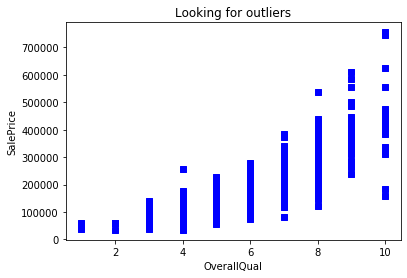

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.scatter(df_train.OverallQual, df_train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")
plt.show()

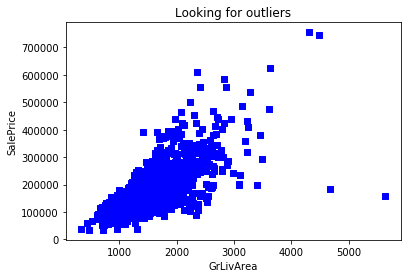

In [4]:
plt.scatter(df_train.GrLivArea, df_train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [5]:
#Looking at variables that are the most correlated with saleprice (overall quality, and general living area) we see that
#there are no obvious outliers due to overall quality. However, there are two points that stand out when we look at the
#general living area where houses with more tha 4000 sf of area have a price lower than 300k. The rest seem to fall on a 
#trendline

In [6]:
#Dropping two outlier points where the price does not seem to match the general living area

df_train.drop(df_train[(df_train.GrLivArea > 4000) & (df_train.SalePrice < 400000)].index, axis=0, inplace = True)

In [7]:
#Looking through all the missing values in the training set, most are NA because that feature does not exist in the house. I am
#substituting those NAs with 'None' in both the training set and test set, or 0, if the values are integers.
#In one instance, there was a missing value on index 332 for the training set that did not seem to be missing due to a missing
#feature (BsmtFinType2 was missing, but all other values for basements were present). In this instance, I used the mode of the
#column in the training set to replace that value.

df_train["Alley"] = df_train["Alley"].fillna('None')
df_test["Alley"] = df_test["Alley"].fillna('None')
df_train["LotFrontage"] = df_train["LotFrontage"].fillna(0)
df_test["LotFrontage"] = df_test["LotFrontage"].fillna(0)
df_train["MasVnrType"] = df_train["MasVnrType"].fillna("None")
df_test["MasVnrType"] = df_test["MasVnrType"].fillna("None")
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(0)
df_test["MasVnrArea"] = df_test["MasVnrArea"].fillna(0)
df_train["BsmtQual"] = df_train["BsmtQual"].fillna("None")
df_test["BsmtQual"] = df_test["BsmtQual"].fillna("None")
df_train["BsmtCond"] = df_train["BsmtCond"].fillna("None")
df_test["BsmtCond"] = df_test["BsmtCond"].fillna("None")
df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna("None")
df_test["BsmtExposure"] = df_test["BsmtExposure"].fillna("None")
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].fillna("None")
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].fillna("None")
df_train["BsmtFinSF1"] = df_train["BsmtFinSF1"].fillna(0)
df_test["BsmtFinSF1"] = df_test["BsmtFinSF1"].fillna(0)
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna("None")
df_train["BsmtFinType2"][332] = df_train["BsmtFinType2"].mode()[0]
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].fillna("None")
df_train["BsmtFinSF2"] = df_train["BsmtFinSF2"].fillna(0)
df_test["BsmtFinSF2"] = df_test["BsmtFinSF2"].fillna(0)
df_train["BsmtUnfSF"] = df_train["BsmtUnfSF"].fillna(0)
df_test["BsmtUnfSF"] = df_test["BsmtUnfSF"].fillna(0)
electrical_mode = df_train["Electrical"].mode()[0]
df_train["Electrical"].fillna(electrical_mode, inplace=True)
df_test["Electrical"].fillna(electrical_mode, inplace = True)
df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna("None")
df_test["FireplaceQu"] = df_train["FireplaceQu"].fillna("None")
df_train[['GarageType','GarageFinish','GarageQual','GarageCond']] = df_train[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna("None")
df_test[['GarageType','GarageFinish','GarageQual','GarageCond']] = df_test[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna("None")
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].fillna(0)
df_test["GarageYrBlt"] = df_test["GarageYrBlt"].fillna(0)
df_train["PoolQC"] = df_train["PoolQC"].fillna("None")
df_test["PoolQC"] = df_test["PoolQC"].fillna("None")
df_train[['Fence','MiscFeature']] = df_train[['Fence','MiscFeature']].fillna('None')
df_test[['Fence','MiscFeature']] = df_test[['Fence','MiscFeature']].fillna('None')



C:\Users\rishabh.chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#There were quite a few missing values in the test set from columns that did not have missing values in the training set
#For this, I am using the mode for categorical variables, and mean for numerical variables, from the training set to fill
#in values for the test set.

MSZoning_mode = df_train['MSZoning'].mode()[0]
Utilities_mode = df_train['Utilities'].mode()[0]
Exterior1st_mode = df_train['Exterior1st'].mode()[0]
Exterior2nd_mode = df_train['Exterior2nd'].mode()[0]
TotalBsmtSF_mean = df_train['TotalBsmtSF'].mean()
BsmtFullBath_mean = df_train['BsmtFullBath'].mean()
BsmtHalfBath_mean = df_train['BsmtHalfBath'].mean()
KitchenQual_mode = df_train['KitchenQual'].mode()[0]
Functional_mode = df_train['Functional'].mode()[0]
GarageCars_mean = df_train['GarageCars'].mean()
GarageArea_mean = df_train['GarageArea'].mean()
SaleType_mode = df_train['SaleType'].mode()[0]

df_test['MSZoning'].fillna(MSZoning_mode, inplace=True)
df_test['Utilities'].fillna(Utilities_mode, inplace=True)
df_test['Exterior1st'].fillna(Exterior1st_mode, inplace=True)
df_test['Exterior2nd'].fillna(Exterior2nd_mode, inplace=True)
df_test['TotalBsmtSF'].fillna(TotalBsmtSF_mean, inplace=True)
df_test['BsmtFullBath'].fillna(BsmtFullBath_mean, inplace=True)
df_test['BsmtHalfBath'].fillna(BsmtHalfBath_mean, inplace=True)
df_test['KitchenQual'].fillna(KitchenQual_mode, inplace=True)
df_test['Functional'].fillna(Functional_mode, inplace=True)
df_test['GarageCars'].fillna(GarageCars_mean, inplace=True)
df_test['GarageArea'].fillna(GarageArea_mean, inplace=True)
df_test['SaleType'].fillna(SaleType_mode, inplace=True)

In [9]:
#MSSubClass is definitely a categorical variable, not numerical. I also turned month into a categorical variable, otherwise
#the regression would think 12 (december) is better than 4(April)

df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)
df_test['MSSubClass'] = df_test['MSSubClass'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
Id               1458 non-null int64
MSSubClass       1458 non-null object
MSZoning         1458 non-null object
LotFrontage      1458 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null object
Alley            1458 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1458 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior1st      1458 no

In [11]:
#importing all the libraries needed to run Ridge, Lasso, Random Forest regressions and make pipelines

from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

ore = OrdinalEncoder()
ohe = OneHotEncoder()
se = StandardScaler()

In [12]:
#Creating the X and y variables
y = np.log(df_train['SalePrice'])
df_train.drop('SalePrice',axis=1,inplace=True)
X_test = df_test['Id']
df_train.drop('Id',axis=1,inplace=True)
df_test.drop('Id',axis=1,inplace=True)


In [13]:
#Creating all the mappings for ordinal variables. There were a lot more ordinal variables in the full dataset.


garage_mapping = {
    'None': 1,
    'Unf': 2,
    'RFn': 3,
    'Fin': 4
}

colGar_mapping = {
    'col': 'GarageFinish',
    'mapping': garage_mapping
}

utilities_mapping = {
    'None': 1,
    'ELO': 2,
    'NoSeWa': 3,
    'NoSewr': 4,
    'AllPub': 5
}

colUtil_mapping = {
    'col': 'Utilities',
    'mapping': utilities_mapping
}

street_mapping = {
    'Grvl': 1,
    'Pave': 2
}

colStr_mapping = {
    'col': 'Street',
    'mapping': street_mapping
}

landslope_mapping = {
    'Gtl': 3,
    'Mod': 2,
    'Sev': 1
}

colLandSl_mapping = {
    'col': 'LandSlope',
    'mapping': landslope_mapping
}

qual_mapping = {
    'None': 1,
    'Po': 2,
    'Fa': 3,
    'TA': 4,
    'Gd': 5,
    'Ex': 6
}

colExterQual_mapping = {
    'col': 'ExterQual',
    'mapping': qual_mapping
}

colExterCond_mapping = {
    'col': 'ExterCond',
    'mapping': qual_mapping
}

colBsmtQual_mapping = {
    'col': 'BsmtQual',
    'mapping': qual_mapping
}

colBsmtCond_mapping = {
    'col': 'BsmtCond',
    'mapping': qual_mapping
}

colHeatingQC_mapping = {
    'col': 'HeatingQC',
    'mapping': qual_mapping
}

colKitchenQual_mapping = {
    'col': 'KitchenQual',
    'mapping': qual_mapping
}

colFireplaceQu_mapping = {
    'col': 'FireplaceQu',
    'mapping': qual_mapping
}

colGarageQual_mapping = {
    'col': 'GarageQual',
    'mapping': qual_mapping
}

colGarageCond_mapping = {
    'col': 'GarageCond',
    'mapping': qual_mapping
}

colPoolQC_mapping = {
    'col': 'PoolQC',
    'mapping': qual_mapping
}

bsmtexp_mapping = {
    'None': 1,
    'No': 2,
    'Mn': 3,
    'Av': 4,
    'Gd': 5
}

colBsmtExposure_mapping = {
    'col': 'BsmtExposure',
    'mapping': bsmtexp_mapping
}

bsmtfintyp_mapping = {
    'None': 1,
    'Unf': 2,
    'LwQ': 3,
    'Rec': 4,
    'BLQ': 5,
    'ALQ': 6,
    'GLQ': 7
}

colBsmtFinType1_mapping = {
    'col': 'BsmtFinType1',
    'mapping': bsmtfintyp_mapping
}

colBsmtFinType2_mapping = {
    'col': 'BsmtFinType2',
    'mapping': bsmtfintyp_mapping
}

centralair_mapping = {
    'N': 1,
    'Y': 2
}
colCentralAir_mapping = {
    'col': 'CentralAir',
    'mapping': centralair_mapping
}

functional_mapping = {
    'Sal': 1,
    'Sev': 2,
    'Maj2': 3,
    'Maj1': 4,
    'Mod': 5,
    'Min2': 6,
    'Min1': 7,
    'Typ': 8
}
colFunctional_mapping = {
    'col': 'Functional',
    'mapping': functional_mapping
}

paveddrive_mapping = {
    'N': 1,
    'P': 2,
    'Y': 3
}
colPavedDrive_mapping = {
    'col': 'PavedDrive',
    'mapping': paveddrive_mapping
}

In [14]:
#Creating the ordinal encodings
ore = OrdinalEncoder(cols=['GarageFinish','Utilities','Street','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC','BsmtExposure','BsmtFinType1','BsmtFinType2','CentralAir','Functional','PavedDrive'],mapping=[colGar_mapping,colUtil_mapping,colStr_mapping,colLandSl_mapping,colExterQual_mapping,colExterCond_mapping,colBsmtQual_mapping,colBsmtCond_mapping,colHeatingQC_mapping,colKitchenQual_mapping,colFireplaceQu_mapping,colGarageQual_mapping,colGarageCond_mapping,colPoolQC_mapping,colBsmtExposure_mapping,colBsmtFinType1_mapping,colBsmtFinType2_mapping,colCentralAir_mapping,colFunctional_mapping,colPavedDrive_mapping])

In [15]:
#Fitting the ordinal encodings to training
ore.fit_transform(df_train)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2,None,Reg,Lvl,5,Inside,...,0,0,1,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,2,None,Reg,Lvl,5,FR2,...,0,0,1,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,2,None,IR1,Lvl,5,Inside,...,0,0,1,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,2,None,IR1,Lvl,5,Corner,...,0,0,1,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,2,None,IR1,Lvl,5,FR2,...,0,0,1,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,2,None,Reg,Lvl,5,Inside,...,0,0,1,None,None,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,2,None,Reg,Lvl,5,Inside,...,0,0,1,MnPrv,None,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,2,None,Reg,Lvl,5,Inside,...,0,0,1,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,2,None,Reg,Lvl,5,Inside,...,0,0,1,None,None,0,4,2010,WD,Normal


In [16]:
#Initializing one hot encoder
ohe = OneHotEncoder()

In [17]:
#Fitting one hot encoder
ohe.fit_transform(df_train)

,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,MSSubClass_9,MSSubClass_10,...,SaleType_6,SaleType_7,SaleType_8,SaleType_9,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1456,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1457,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1458,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [18]:
#Initializign Ridge Regression
ridge = Ridge()
pipe_rd = make_pipeline(ore,ohe,se,ridge)

In [19]:
#Fitting Ridge Regression
pipe_rd.fit(df_train,y)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GarageFinish', 'Utilities', 'Street',
                                      'LandSlope', 'ExterQual', 'ExterCond',
                                      'BsmtQual', 'BsmtCond', 'HeatingQC',
                                      'KitchenQual', 'FireplaceQu',
                                      'GarageQual', 'GarageCond', 'PoolQC',
                                      'BsmtExposure', 'BsmtFinType1',
                                      'BsmtFinType2', 'CentralAir',
                                      'Functional', 'PavedDrive'],
                                drop_invariant=False, handle_m...
                                     'CentralAir', ...],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('standardsca

In [20]:
# Testing which is the best alpha for using ridge regression:
alphas = np.logspace(-3,3,7)
scores_rd = []

for alpha in alphas:
    pipe_rd.steps[-1][1].set_params(alpha=alpha)
    scores = cross_val_score(estimator=pipe_rd, X=df_train, y=y, cv=15)
    scores_rd.append((np.mean(scores), np.min(scores), np.max(scores),alpha))

scores_rd

[(0.8967144090274922, 0.8694971147686741, 0.9257453062064407, 0.001),
 (0.8967513893159821, 0.8695037443944937, 0.9257641138487339, 0.01),
 (0.8969747460628892, 0.869567578965168, 0.9259264625103448, 0.1),
 (0.8974140894997144, 0.8700898475196467, 0.926698298195122, 1.0),
 (0.9004359123764502, 0.8726561276918172, 0.9292673475151636, 10.0),
 (0.9091098611325875, 0.8792357941060294, 0.9367393173404974, 100.0),
 (0.9084712983685878, 0.8678507600964305, 0.9396549117248294, 1000.0)]

In [21]:
#An alpha of 100 seems to be best. It has the highest mean, and the highest min value

In [22]:
np.logspace(1.5,2,7)

array([ 31.6227766 ,  38.3118685 ,  46.41588834,  56.23413252,
        68.12920691,  82.54041853, 100.        ])

In [23]:
# Trying to further refine the value alpha for using ridge regression:
alphas = np.logspace(2,2.5,7)
scores_rd = []

for alpha in alphas:
    pipe_rd.steps[-1][1].set_params(alpha=alpha)
    scores = cross_val_score(estimator=pipe_rd, X=df_train, y=y, cv=15)
    scores_rd.append((np.mean(scores), np.min(scores), np.max(scores),alpha))

scores_rd

[(0.9091098611325875, 0.8792357941060294, 0.9367393173404974, 100.0),
 (0.9099258655268817,
  0.8798367885930733,
  0.9374984440840114,
  121.15276586285889),
 (0.9107037577070346,
  0.8804275270145924,
  0.9382510427100397,
  146.7799267622069),
 (0.911420587513049,
  0.881007555288292,
  0.9389872646489648,
  177.82794100389228),
 (0.9120481524871982,
  0.8815747067575298,
  0.9396927659229625,
  215.44346900318845),
 (0.9125524815560403,
  0.8821226437073428,
  0.9403467899761482,
  261.0157215682536),
 (0.9128935225170376,
  0.8826381017393609,
  0.9409203171478375,
  316.22776601683796)]

In [24]:
# Trying to further refine the value alpha for using ridge regression:
alphas = np.logspace(2.5,3,7)
scores_rd = []

for alpha in alphas:
    pipe_rd.steps[-1][1].set_params(alpha=alpha)
    scores = cross_val_score(estimator=pipe_rd, X=df_train, y=y, cv=15)
    scores_rd.append((np.mean(scores), np.min(scores), np.max(scores),alpha))

scores_rd

[(0.9128935225170376,
  0.8826381017393609,
  0.9409203171478375,
  316.22776601683796),
 (0.913025026652336,
  0.8830980834415941,
  0.9413744344423779,
  383.1186849557289),
 (0.9128945442565193,
  0.8828689624459871,
  0.9416590135191758,
  464.15888336127773),
 (0.9124433536040975,
  0.8800311703963654,
  0.9417117030823363,
  562.341325190349),
 (0.9116060656733297, 0.87662432212003, 0.9414571437834928, 681.2920690579615),
 (0.9103096059972938,
  0.872586518099394,
  0.9408062015312835,
  825.4041852680182),
 (0.9084712983685878, 0.8678507600964305, 0.9396549117248294, 1000.0)]

In [25]:
#Calculating test scores using an alpha of 383
pipe_rd.steps[-1][1].set_params(alpha=383)
preds_rd = pipe_rd.predict(df_test)

submission_rd = pd.DataFrame({
    'Id': np.arange(1461,2920),
    'SalePrice': np.exp(preds_rd)
})

submission_rd.to_csv('submission_rd.csv', index=False)

#This submission yielded a score of 0.13696 which is better than what we had in class using Linear Regression (0.14)

In [26]:
lasso = Lasso()
pipe_ls = make_pipeline(ore,ohe,se,lasso)
pipe_ls.fit(df_train,y)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GarageFinish', 'Utilities', 'Street',
                                      'LandSlope', 'ExterQual', 'ExterCond',
                                      'BsmtQual', 'BsmtCond', 'HeatingQC',
                                      'KitchenQual', 'FireplaceQu',
                                      'GarageQual', 'GarageCond', 'PoolQC',
                                      'BsmtExposure', 'BsmtFinType1',
                                      'BsmtFinType2', 'CentralAir',
                                      'Functional', 'PavedDrive'],
                                drop_invariant=False, handle_m...
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mea

In [27]:
# Testing which is the best alpha for using lasso regression:
alphas = np.logspace(-3,3,7)
scores_ls = []

for alpha in alphas:
    pipe_ls.steps[-1][1].set_params(alpha=alpha)
    scores = cross_val_score(estimator=pipe_ls, X=df_train, y=y, cv=15)
    scores_ls.append((np.mean(scores), np.min(scores), np.max(scores),alpha))

scores_ls

[(0.9160240062105913, 0.8881496954976448, 0.9397336915585486, 0.001),
 (0.9142851380715922, 0.887249791928782, 0.9414092015177083, 0.01),
 (0.7270402535837779, 0.6528773630346186, 0.7833597024398881, 0.1),
 (-0.00827140823733168, -0.04425766773653472, -0.0002716419591679564, 1.0),
 (-0.00827140823733168, -0.04425766773653472, -0.0002716419591679564, 10.0),
 (-0.00827140823733168, -0.04425766773653472, -0.0002716419591679564, 100.0),
 (-0.00827140823733168, -0.04425766773653472, -0.0002716419591679564, 1000.0)]

In [28]:
# Trying to further refine the value alpha for using lasso regression:
alphas = np.logspace(-3,-2,7)
scores_ls = []

for alpha in alphas:
    pipe_ls.steps[-1][1].set_params(alpha=alpha)
    scores = cross_val_score(estimator=pipe_ls, X=df_train, y=y, cv=15)
    scores_ls.append((np.mean(scores), np.min(scores), np.max(scores),alpha))

scores_ls

[(0.9160240062105913, 0.8881496954976448, 0.9397336915585486, 0.001),
 (0.9191913670860323,
  0.889142119061648,
  0.9441424154488022,
  0.0014677992676220691),
 (0.9210519950264918,
  0.8913655744816276,
  0.9451843688397676,
  0.0021544346900318843),
 (0.9220231855302793,
  0.8920675976800061,
  0.9460220284620697,
  0.0031622776601683794),
 (0.9217304494329056,
  0.8923584044883732,
  0.945504019738225,
  0.004641588833612777),
 (0.9199217279826102,
  0.8927720555834499,
  0.9444018237107974,
  0.006812920690579608),
 (0.9142851380715922, 0.887249791928782, 0.9414092015177083, 0.01)]

In [29]:
#Calculating test scores using an alpha of 0.00316
pipe_ls.steps[-1][1].set_params(alpha=0.003162)
preds_ls = pipe_ls.predict(df_test)

submission_ls = pd.DataFrame({
    'Id': np.arange(1461,2920),
    'SalePrice': np.exp(preds_ls)
})

submission_ls.to_csv('submission_ls.csv', index=False)

#This submission yielded a score of 0.419 which was very surprising, the fit on the lasso model was showing a higher fit (0.92) 
#than what i had with the ridge regression.

In [30]:
rf = RandomForestRegressor()

rf_pipe = make_pipeline(ore, ohe, rf)

rf_pipe.fit(df_train,y)

C:\Users\rishabh.chandra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GarageFinish', 'Utilities', 'Street',
                                      'LandSlope', 'ExterQual', 'ExterCond',
                                      'BsmtQual', 'BsmtCond', 'HeatingQC',
                                      'KitchenQual', 'FireplaceQu',
                                      'GarageQual', 'GarageCond', 'PoolQC',
                                      'BsmtExposure', 'BsmtFinType1',
                                      'BsmtFinType2', 'CentralAir',
                                      'Functional', 'PavedDrive'],
                                drop_invariant=False, handle_m...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impuri

In [31]:
# Testing which leaf sample is the best for random forests:
leaf_samples = [1,5,10,15,20,25]
scores_rf = []

for leaf in leaf_samples:
    rf_pipe.steps[-1][1].set_params(min_samples_leaf=leaf)
    scores = cross_val_score(estimator=rf_pipe, X=df_train, y=y, cv=15)
    scores_rf.append((np.mean(scores), np.min(scores), np.max(scores),leaf))

scores_rf

[(0.8720029027703242, 0.7955170707713438, 0.9274941818190806, 1),
 (0.8689335215084669, 0.8161808187542815, 0.9174059967125962, 5),
 (0.8564758242401586, 0.8027937900408265, 0.9084733443744084, 10),
 (0.8469167631473996, 0.8025247448173622, 0.9183430335366992, 15),
 (0.8315008134552805, 0.7824766631097045, 0.9089099046988828, 20),
 (0.8255057585929693, 0.7637325615702508, 0.8898938559881617, 25)]

In [32]:
#Calculating test scores using a leafsize of 1
rf_pipe.steps[-1][1].set_params(min_samples_leaf=1)
preds_rf = rf_pipe.predict(df_test)

submission_rf = pd.DataFrame({
    'Id': np.arange(1461,2920),
    'SalePrice': np.exp(preds_rf)
})

submission_rf.to_csv('submission_rf.csv', index=False)

#This submission yeilded a score of 0.15564, which is higher than Lasso, but less tha Ridge. Ridge regression seems to be the
#best out of three thus far